## Neural Networks for Regression 

In this notebook the main aim of the project is performing regression using different architectures of Neural Networks which are Full MLPs, Full RBFs, Extreme MLP, Extreme RBF, Block decomposition for RBF nws.  


## Data Set 

The dataset is generated using Franke's Function which has two Gaussian peaks of different heights, and a smaller dip. It is used as a test function in interpolation problems. 

https://www.sfu.ca/~ssurjano/franke2d.html

![title](franke_function.png)


### Generating Dataset 


The data set is obtained by sampling on 100 random points x_i from the function and adding a uniform noise, 
i.e. yi = f(xi) + εi and εi is a random number in [−10−1,10−1].






In [4]:
import pandas as pd
import random
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import sample



'''Generate 100 random points in R2'''
def generate_dependent_variables(seed=1772576):
    np.random.seed(seed)    
    X = np.random.uniform(low=0.0,high=1.0,size=(100,2))
    return X

'''Generate random Noise'''
def generate_random_noise(seed=1772576):
    np.random.seed(seed)
    noise = np.random.uniform(low=-0.1,high=0.1,size=100)
    return noise

'''Generate Data Set'''
def generate_data():
    X = generate_dependent_variables(seed=1772576)
    noise = generate_random_noise(seed=1772576)
    Y = np.zeros(shape=len(X))
    counter = 0
    for vector in X:
        x1 = vector[0]
        x2 = vector[1]
        term1 = 0.75 * (math.exp(-(np.square((9*x1)-2)/4)-(np.square((9*x2)-2)/4)))
        term2 = 0.75 * (math.exp(-(np.square((9*x1)+1)/49)-((9*x2)+1)/10))
        term3 = 0.5 * (math.exp(-(np.square((9*x1)-7)/4)-(np.square((9*x2)-3)/4)))
        term4 = 0.2 * (math.exp(-(np.square((9*x1)-4))-(np.square((9*x2)-7))))
        Y[counter] = term1+term2+term3-term4
        counter+=1
    return X,Y+noise

def divide_dataset(X,y):
    random.seed(1772576)
    indices = sample(range(len(X)),int(0.70*len(X)))
    X_train = X[indices]
    mask = np.ones(len(X), dtype=bool)
    mask[indices] = False
    X_test = X[mask]
    y_train = y[indices]
    y_test = y[mask]
    return X_train,y_train,X_test,y_test

X, y = generate_data()

X_train,y_train,X_test,y_test = divide_dataset(X,y)

## Full MLP Network
Consider a shallow Feedforward Neural Network (FNN) (only one hidden layer) that approximates the franke's function. We will select a MLP network,  ω are the parameters to be found out by the optimization procedure and π the hyper-parameters of the network to be found by means of an heuristic procedure using gridsearch etc. 

![title](function.png)

ρ in the range [10−5 ÷10−3] is one of the hyper parameters.

![title](function2.png)
![title](function3.png)

![title](mlp.png)


### Initializing parameters 
The input data is of the shape p x n where there are p number of data points with n columns (in our dataset p = 100, n = 2).

w which is the matrix of weights between the input layer and the hidden layer will be of dimensions N x n,where N is number of hidden units in the hidden layer. N will be selected through gridsearch eventually. 

v is the vector of weights between the hidden layer and one output unit of the dimension N x 1.

b is vector of bias units for every unit of hidden layer. it is of the dimension N x 1. 



In [7]:
#header 
import numpy as np
import OMML_gen_data as data   #script to generate data
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

def init_parameters(Num_nuerons = 10, X = data.X_train):

    No_nueron_units = Num_nuerons
    np.random.seed(1772576)
    v = np.random.rand(No_nueron_units,1)                 #vector of length equal to no of neurons N x 1
    w = np.random.rand(No_nueron_units,X.shape[1])        #matrix of dimension N x n
    b = np.random.rand(No_nueron_units,1)                 # N x 1
    shapes = (v.shape,w.shape,b.shape)
    vctr = toVector(v,w,b)
    
    return(vctr,shapes)

### Implementing the function f(x) (for neural network) and the activation function. 


In [8]:
#this is the activation function g() as written in the equations
def g(t,sigma):
    val = (1-np.exp(-sigma*t))/(1+np.exp(-sigma*t))
    return val

#this is the approximating function f(x) of the Neural network 
def fx(X,v,w,b,sig):
    
    #dimensions of X  = p x n
    
    #(v,w,b) = params
    #v                  #vector of length equal to no of neurons N x 1
    #w                  #matrix of dimension N x n
    #b                  # N x 1
    
    #np.tanh(np.dot(w,X.T) - b)                        # N x p 
    
    
    f_xp = np.dot(v.T,g((np.dot(w,X.T) - b),sig))           #1xN x Nxp = 1xp vector
    return f_xp.T

#cost function or loss function which will optimize the least squares between f(x) and true labels y. 

def cost_function(vctr,X,y,roh,shapes,sigma):
    
#     No_nueron_units = 3
#     v = np.empty([No_nueron_units,1])                 #vector of length equal to no of neurons N x 1
#     w = np.empty([No_nueron_units,X.shape[1]])        #matrix of dimension N x n
#     b = np.empty([No_nueron_units,1])                 # N x 1
#     params = [v,w,b]
    
    v,w,b = toWZ(vctr,shapes)
    
    reg_term = roh*np.sqrt(np.sum(abs(w)**2) + np.sum(abs(b)**2) + np.sum(abs(v)**2))
    cost = np.sum((fx(X,v,w,b,sigma).reshape(X.shape[0],1) - y.reshape(len(y),1))**2)/(2*len(y)) + reg_term
    
    return cost

#### Some Supporting functions

In [9]:

def toVector(v, w, b):
    assert v.shape == (v.shape[0], v.shape[1])
    assert w.shape == (w.shape[0], w.shape[1])
    assert b.shape == (b.shape[0], b.shape[1])
    return np.hstack([v.flatten(), w.flatten(),b.flatten()])

def toWZ(vec,shapes):
    
    vshape,wshape,bshape = shapes
    v1 = vec[:vshape[0]*vshape[1]].reshape(vshape[0],vshape[1])
    v2 = vec[vshape[0]*vshape[1]:vshape[0]*vshape[1]+wshape[0]*wshape[1]].reshape(wshape[0],wshape[1])
    v3 = vec[-bshape[0]*bshape[1]:].reshape(bshape[0],bshape[1])
    return v1,v2,v3

### Optimizing the parameters
To define an optimization problem:
1. choose a measure of closeness, loss function l 
typical loss functions can be : quadratic squared loss |f(x) - y|^2 , hinge loss, logistic loss....etc. 
2. choose a class of functions f 
3. choose regularization term R
Regularization term R(W,λ) = λ*|W|^2 (l2 norm ridge and l1 norm for lasso)


The minimization problem of finding the optimal parameters w,v,b is an unconstrained optimization problem (not really sure about the mathematics ...) but it can be optimized using BFGS,CG routines ( available in the scipy library https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). 

The hyperparameters N,λ,ρ are found out using gridsearchCV.There are even better methods like gaussian processes for hyperparameter tuning but it is computationally expensive ( https://arxiv.org/pdf/1609.08703.pdf , https://thuijskens.github.io/2016/12/29/bayesian-optimisation/ ). 




In [10]:
#function to implement optimization and gridsearch. This returns the predicted value y,optimal v,w,b and hyperparameters
# N,roh,sigma.
def gridsearch(X_train,y_train,X_test,y_test,N_vec=[4,10,20],roh_vec=[0.0001,0.01,0.05,0.1,3,0.0003],sigma_vec = [0.001,0.1,0.05]):
    X = X_train
    yy = y_train.reshape(len(y_train),1)

    dumpdct={}
    cnt = 0
    for N in N_vec:
        vctr,shapes = init_parameters(N,X)
        for roh in roh_vec:
            for sigma in sigma_vec:
                cnt = cnt+1
                res = minimize(cost_function, vctr,args=(X,yy,roh,shapes,sigma),method='BFGS',options={'disp': True,'maxiter':30000})
                v_hat,w_hat,b_hat = toWZ(res.x,shapes)
                #res.fun                                        #train error
                err = cost_function(res.x,X_test,y_test,roh,shapes,sigma)    #test error
                dumpdct[cnt] = {'N':N,'roh':roh,'sigma':sigma,'train_error':res.fun,'test_error':err}

                
                
    #select parameters with lowest test and train errors
    param_dct = select_parameters_mlp(dumpdct)
    
    #test set predictions on these parameters
    vctr,shapes = init_parameters(param_dct['N'],X_train)

    res_test = minimize(cost_function, vctr,args=(X,yy,param_dct['roh'],shapes,param_dct['sigma']),method='Nelder-Mead',options={'disp': True,'maxiter':30000})
    v_hat,w_hat,b_hat = toWZ(res_test.x,shapes)
    y_hat = fx(X_test,v_hat,w_hat,b_hat,param_dct['sigma'])
    
    return y_hat,v_hat,w_hat,b_hat,param_dct,dumpdct

#supporting function
def select_parameters_mlp(dct_object):
    # Find parameters having lowest test and train error.
    tst_error_list = []
    train_error_list = []
    for i in dct_object:
        tst_error_list.append(dct_object[i]['test_error'])
        train_error_list.append(dct_object[i]['train_error'])

    a,b = tst_error_list.index(min(tst_error_list)),train_error_list.index(min(train_error_list))
    return dct_object[a+1]
    

In [2]:
X_train = data.X_train
X_test = data.X_test
y_train = data.y_train
y_test = data.y_test

In [308]:
import time

start = time.time()
y_hat,v_hat,w_hat,b_hat,dct_mlp,d = gridsearch(X_train,y_train,X_test,y_test)
end = time.time()
print(end - start)

Optimization terminated successfully.
         Current function value: 0.021514
         Iterations: 117
         Function evaluations: 2394
         Gradient evaluations: 133
Optimization terminated successfully.
         Current function value: 0.009205
         Iterations: 943
         Function evaluations: 18900
         Gradient evaluations: 1050
Optimization terminated successfully.
         Current function value: 0.015340
         Iterations: 152
         Function evaluations: 3150
         Gradient evaluations: 175
         Current function value: 0.158753
         Iterations: 53
         Function evaluations: 3323
         Gradient evaluations: 184
Optimization terminated successfully.
         Current function value: 0.081515
         Iterations: 65
         Function evaluations: 1296
         Gradient evaluations: 72
Optimization terminated successfully.
         Current function value: 0.105501
         Iterations: 61
         Function evaluations: 1188
         Gradient e

In [9]:
##### Uncomment to view to predictions #########################

#pd.DataFrame({'x':y_hat.reshape(len(y_hat)),'y':y_test})
#pd.reset_option('^display.', silent=True)
#pd.set_option('display.float_format', lambda x: '%.5f' % x)


### Plots for approximating function found

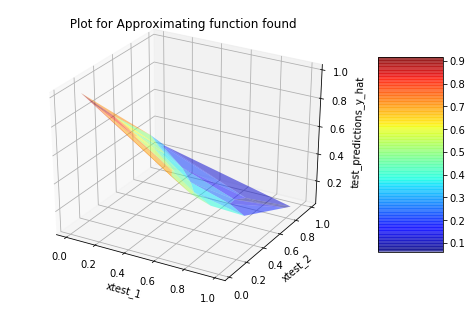

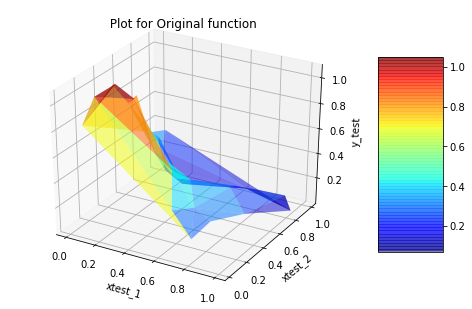

In [117]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X_test[:,0].flatten(), X_test[:,1].flatten(), y_hat.flatten(), cmap=cm.jet, 
                       linewidth=0.2, antialiased=True,alpha=0.5)

fig.colorbar(surf, shrink=10, aspect=3)

ax.set_xlabel('xtest_1')
ax.set_ylabel('xtest_2')
ax.set_zlabel('test_predictions_y_hat')
plt.title(' Plot for Approximating function found ')
plt.show()


fig2 = plt.figure()
ax2 = Axes3D(fig2)
surf = ax2.plot_trisurf(X_test[:,0].flatten(), X_test[:,1].flatten(), y_test.flatten(), cmap=cm.jet, linewidth=0.1,alpha=0.5)
fig2.colorbar(surf, shrink=10, aspect=3)

ax2.set_xlabel('xtest_1')
ax2.set_ylabel('xtest_2')
ax2.set_zlabel('y_test')
plt.title(' Plot for Original function ')
plt.show()



## Full RBF Network

![title](rbfimage.png)
For the RBF networks the approximating function changes to : 
![title](rbf.png)

Here there are no weights between the input layer and hidden layer, its just directly fed into the network. The function φ(·)is the gaussian function ![title](rbf2.PNG).

The minimization problem and the loss function remains the same as before. 

### Initializing parameters

The vector v is the vector of weights from each of the hidden units to output unit. 
C is the matrix of centers which is of the dimension N x n. 


In [12]:

def init_parameters_rbf(Num_nuerons = 10, X = data.X_train):

    No_nueron_units = Num_nuerons
    v = np.random.rand(No_nueron_units,1)                 #vector of length equal to no of neurons N x 1
    c = np.random.rand(No_nueron_units,X.shape[1])        # N x n 
    shapes = (v.shape,c.shape)
    vctr = toVector_rbf(v,c)
    
    return(vctr,shapes)

### Supporting functions
def toVector_rbf(v, c):
    assert v.shape == (v.shape[0], v.shape[1])
    assert c.shape == (c.shape[0], c.shape[1])
    return np.hstack([v.flatten(), c.flatten()])

def toWZ_rbf(vec,shapes):
    
    vshape,cshape = shapes
    v1 = vec[:vshape[0]*vshape[1]].reshape(vshape[0],vshape[1])
    v2 = vec[-cshape[0]*cshape[1]:].reshape(cshape[0],cshape[1])
    return v1,v2

## Loss function and approximating function for RBF nw.

In [13]:

#gauss function phi 
def gauss(t,ci,sigma):
    
    #c=c.reshape(len(c),1)
    k = np.sqrt(np.sum((abs(t-ci)**2),axis = 1))
    val = np.exp(-((k/sigma)**2))
    
    return val

#approximating function
def fx_rbf(X,v,c,sigma):
    
    #dimensions of X  = p x n
    #v  vector of length equal to no of neurons N x 1
    #c  vector of length equal to no of neurons N x 1
    if v.shape[0]!=c.shape[0]:
        raise(Exception('v,c, should have same length !'))
    
    v = v.reshape(len(v),1)
    gauss_mat = np.empty([X.shape[0],v.shape[0]])
    
    for i in range(c.shape[0]):
        gauss_mat[:,i] = gauss(X,c[i],sigma)
        
    
    
    out = np.dot(gauss_mat,v)   #pxN x Nx1 = px1 vector
                                                    
    return out

#this is the loss function
def cost_function_rbf(vctr,X,y,roh,shapes,sigma):
    
#     No_nueron_units = 3
#     v = np.empty([No_nueron_units,1])                 #vector of length equal to no of neurons N x 1
#     w = np.empty([No_nueron_units,X.shape[1]])        #matrix of dimension N x n
#     b = np.empty([No_nueron_units,1])                 # N x 1
#     params = [v,w,b]
    
    v,c = toWZ_rbf(vctr,shapes)
    
    reg_term = roh*np.sqrt(np.sum(abs(v)**2) + np.sum(abs(c)**2))
    cost = np.sum((fx_rbf(X,v,c,sigma).reshape(X.shape[0],1) - y.reshape(len(y),1))**2)/(2*len(y)) + reg_term
    
    return cost



### Optimizing the parameters

Just like before the minimization problem remains the same which is unconstrained minimization with respect to parameters v and c. As before the parameters N,regularization parameter roh, and bandwidth sigma are selected according to gridsearchCV. 

In [14]:

def select_parameters_rbf(dct_object):
    # Find parameters having lowest test and train error.
    tst_error_list = []
    train_error_list = []
    for i in dct_object:
        tst_error_list.append(dct_object[i]['test_error'])
        train_error_list.append(dct_object[i]['train_error'])

    a,b = tst_error_list.index(min(tst_error_list)),train_error_list.index(min(train_error_list))
    return dct_object[a+1]



def gridsearch_rbf(X_train,y_train,X_test,y_test,N_vec=[4,10,20],roh_vec=[0.0001,0.01,0.05,0.1,3,0.0003],sigma_vec = [0.001,0.1,0.05]):
    X = X_train
    yy = y_train.reshape(len(y_train),1)

    dumpdct={}
    cnt = 0
    for N in N_vec:
        vctr,shapes = init_parameters_rbf(N,X)
        for roh in roh_vec:
            for sigma in sigma_vec:
                cnt = cnt+1
                res = minimize(cost_function_rbf, vctr,args=(X,yy,roh,shapes,sigma),method='Nelder-Mead',options={'disp': True,'maxiter':30000})
                v_hat,c_hat = toWZ_rbf(res.x,shapes)
                #res.fun                                        #train error
                err = cost_function_rbf(res.x,X_test,y_test,roh,shapes,sigma)    #test error
                dumpdct[cnt] = {'N':N,'roh':roh,'sigma':sigma,'train_error':res.fun,'test_error':err}
            
    #select parameters with lowest test and train errors
    param_dct = select_parameters_rbf(dumpdct)
    
    #test set predictions on these parameters
    vctr,shapes = init_parameters_rbf(param_dct['N'],X_train)

    res_test = minimize(cost_function_rbf, vctr,args=(X,yy,param_dct['roh'],shapes,param_dct['sigma']),method='Nelder-Mead',options={'disp': True,'maxiter':30000})
    v_hatrbf,c_hatrbf = toWZ_rbf(res_test.x,shapes)
    y_hat_rbf = fx_rbf(X_test,v_hatrbf,c_hatrbf,param_dct['sigma'])
    
    return y_hat_rbf,v_hatrbf,c_hatrbf,param_dct,dumpdct

In [5]:
import time

start_rbf = time.time()
y_hat_rbf,v_hatrbf,c_hatrbf,dct_rbf,d = gridsearch_rbf(X_train,y_train,X_test,y_test)
end_rbf = time.time()
print(end_rbf - start_rbf)




Optimization terminated successfully.
         Current function value: 0.149316
         Iterations: 1824
         Function evaluations: 2565
Optimization terminated successfully.
         Current function value: 0.054645
         Iterations: 1338
         Function evaluations: 1913
Optimization terminated successfully.
         Current function value: 0.113933
         Iterations: 3440
         Function evaluations: 4727
Optimization terminated successfully.
         Current function value: 0.160807
         Iterations: 1921
         Function evaluations: 2686
Optimization terminated successfully.
         Current function value: 0.061091
         Iterations: 7449
         Function evaluations: 10091
Optimization terminated successfully.
         Current function value: 0.133396
         Iterations: 2893
         Function evaluations: 3947
Optimization terminated successfully.
         Current function value: 0.163462
         Iterations: 1470
         Function evaluations: 2061
Optim

In [143]:
##### Uncomment to view to predictions #########################

#pd.DataFrame({'x':y_hat_rbf.reshape(30),'y':y_hat_rbf2.reshape(30),'z':y_test})
#pd.reset_option('^display.', silent=True)
#pd.set_option('display.float_format', lambda x: '%.5f' % x)
#dct_rbf

### Plots

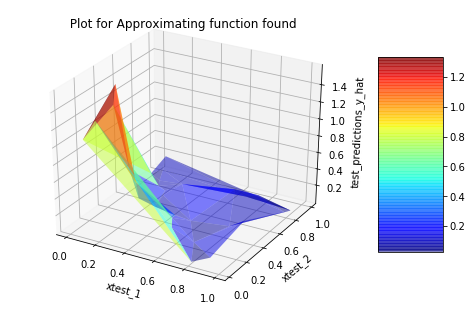

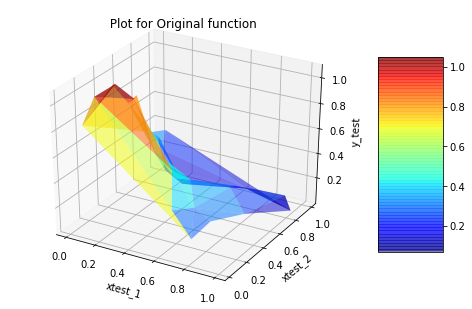

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X_test[:,0].flatten(), X_test[:,1].flatten(), y_hat_rbf.flatten(), cmap=cm.jet, 
                       linewidth=0.2, antialiased=True,alpha=0.5)

fig.colorbar(surf, shrink=10, aspect=3)

ax.set_xlabel('xtest_1')
ax.set_ylabel('xtest_2')
ax.set_zlabel('test_predictions_y_hat')
plt.title(' Plot for Approximating function found ')
plt.show()


fig2 = plt.figure()
ax2 = Axes3D(fig2)
surf = ax2.plot_trisurf(X_test[:,0].flatten(), X_test[:,1].flatten(), y_test.flatten(), cmap=cm.jet, linewidth=0.1,alpha=0.5)
fig2.colorbar(surf, shrink=10, aspect=3)

ax2.set_xlabel('xtest_1')
ax2.set_ylabel('xtest_2')
ax2.set_zlabel('y_test')
plt.title(' Plot for Original function ')
plt.show()



## Extreme learning MLP

Extreme learning MLP is really fast to learn because the optimizer does not optimize the input weights w and bias units b. They are randomly initialized. Only the output weights v are put into the optimizer. 



In [9]:

def init_parameters_mlp2(Num_nuerons = 10, X = data.X_train):

    No_nueron_units = Num_nuerons
    #np.random.seed(1772576)
    v = np.random.rand(No_nueron_units,1)                 #vector of length equal to no of neurons N x 1
    w = np.random.rand(No_nueron_units,X.shape[1])        #matrix of dimension N x n
    b = np.random.rand(No_nueron_units,1)                 # N x 1
    #shapes = (v.shape,w.shape,b.shape)
    #vctr = toVector(v,w,b)
    
    return(v,w,b)



def optimize_mlp(X_train,y_train,X_test,y_test,param_dct):
    X = X_train
    yy = y_train.reshape(len(y_train),1)
            
    #param_dct is the dictionary of parameters of RBF network in Q1 Part 2  
    
    
    #test set predictions on these parameters
    v,w_hatmlp,b_hatmlp = init_parameters_mlp2(param_dct['N'],X_train)
    res = minimize(cost_function_mlp, v,args=(w_hatmlp,b_hatmlp,X_train,y_train,param_dct['roh'],param_dct['sigma']),method='Nelder-Mead',options={'disp': True,'maxiter':30000})
    v_hatmlp = res.x
    y_hat_mlp = fx(X_test,v_hatmlp,w_hatmlp,b_hatmlp,param_dct['sigma'])
    test_se = cost_function_mlp(v_hatmlp,w_hatmlp,b_hatmlp,X_test,y_test,param_dct['roh'],param_dct['sigma'])
    
    return y_hat_mlp,v_hatmlp,w_hatmlp,b_hatmlp,param_dct,test_se


def gridsearch_mlp(X_train,y_train,X_test,y_test,N_vec=[4,10,20],roh_vec=[0.0001,0.01,0.05,0.1,3,0.0003],sigma_vec = [0.001,0.1,0.05]):
    X = X_train
    yy = y_train.reshape(len(y_train),1)

    dumpdct={}
    cnt = 0
    for N in N_vec:
        v,w_hatmlp,b_hatmlp = init_parameters_mlp2(N,X)
        for roh in roh_vec:
            for sigma in sigma_vec:
                cnt = cnt+1
                res = minimize(cost_function_mlp, v,args=(w_hatmlp,b_hatmlp,X_train,y_train,roh,sigma),method='BFGS',options={'disp': True,'maxiter':30000})
                v_hatmlp = res.x
                #res.fun                                                                   #train error
                err = cost_function_mlp(v_hatmlp,w_hatmlp,b_hatmlp,X_test,y_test,roh,sigma)    #test error
                dumpdct[cnt] = {'N':N,'roh':roh,'sigma':sigma,'train_error':res.fun,'test_error':err}

                
                
    #select parameters with lowest test and train errors
    param_dct = select_parameters_mlp(dumpdct)
    
    #test set predictions on these parameters
    v,w_hatmlp,b_hatmlp = init_parameters_mlp2(param_dct['N'],X_train)

    res = minimize(cost_function_mlp, v,args=(w_hatmlp,b_hatmlp,X_train,y_train,param_dct['roh'],param_dct['sigma']),method='BFGS',options={'disp': True,'maxiter':30000})
    v_hatmlp = res.x
    y_hat_mlp = fx(X_test,v_hatmlp,w_hatmlp,b_hatmlp,param_dct['sigma'])   #predictions on test set
    test_se = cost_function_mlp(v_hatmlp,w_hatmlp,b_hatmlp,X_test,y_test,param_dct['roh'],param_dct['sigma'])
    
    return y_hat_mlp,v_hatmlp,w_hatmlp,b_hatmlp,param_dct,test_se


def cost_function_mlp(v,w,b,X,y,roh,sigma):
    
#     No_nueron_units = 3
#     v = np.empty([No_nueron_units,1])                 #vector of length equal to no of neurons N x 1
#     w = np.empty([No_nueron_units,X.shape[1]])        #matrix of dimension N x n
#     b = np.empty([No_nueron_units,1])                 # N x 1
#     params = [v,w,b]
    

    
    reg_term = roh*np.sqrt(np.sum(abs(w)**2) + np.sum(abs(b)**2) + np.sum(abs(v)**2))
    cost = np.sum((fx(X,v,w,b,sigma).reshape(X.shape[0],1) - y.reshape(len(y),1))**2)/(2*len(y)) + reg_term
    
    return cost




In [10]:
import time

start_mlp = time.time()
y_hat_mlp, v_hatmlp, w_hatmlp, b_hatmlp, dct_mlp2,test_error_mlp = gridsearch_mlp(X_train,y_train,X_test,y_test)
end_mlp = time.time()
print(end_mlp-start_mlp)

Optimization terminated successfully.
         Current function value: 0.116847
         Iterations: 6
         Function evaluations: 84
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 0.019173
         Iterations: 41
         Function evaluations: 282
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.021117
         Iterations: 44
         Function evaluations: 306
         Gradient evaluations: 51
Optimization terminated successfully.
         Current function value: 0.176346
         Iterations: 8
         Function evaluations: 72
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.118745
         Iterations: 16
         Function evaluations: 120
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.161214
         Iterations: 18
         Function evaluations: 132


In [18]:
##### Uncomment to view to predictions #########################

#pd.DataFrame({'x':y_hat_mlp.reshape(30),'y':y_test})
#pd.reset_option('^display.', silent=True)
#pd.set_option('display.float_format', lambda x: '%.5f' % x)


## Plots

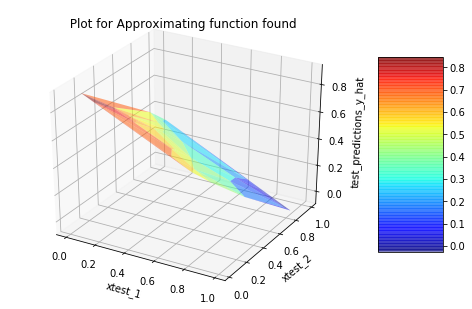

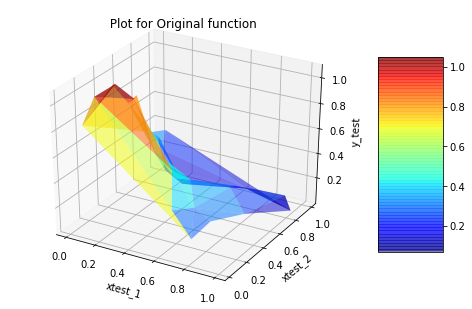

In [12]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X_test[:,0].flatten(), X_test[:,1].flatten(), y_hat_mlp.flatten(), cmap=cm.jet, 
                       linewidth=0.2, antialiased=True,alpha=0.5)

fig.colorbar(surf, shrink=10, aspect=3)

ax.set_xlabel('xtest_1')
ax.set_ylabel('xtest_2')
ax.set_zlabel('test_predictions_y_hat')
plt.title(' Plot for Approximating function found ')
plt.show()


fig2 = plt.figure()
ax2 = Axes3D(fig2)
surf = ax2.plot_trisurf(X_test[:,0].flatten(), X_test[:,1].flatten(), y_test.flatten(), cmap=cm.jet, linewidth=0.1,alpha=0.5)
fig2.colorbar(surf, shrink=10, aspect=3)

ax2.set_xlabel('xtest_1')
ax2.set_ylabel('xtest_2')
ax2.set_zlabel('y_test')
plt.title(' Plot for Original function ')
plt.show()



## Unsupervised Selection of Centers for RBF Model

To make the learning of RBF networks faster, the matrix of centeres C can be randomly initialized or even better it can be chosen in some unsupervised way such as clustering because these kind of networks tend to get a localized response. Something like clustering can prove to be really good in capturing the localized response. 

In [13]:
# Estimate centroids for RBF network by K-Means
from sklearn.cluster import KMeans


In [39]:
#%timeit gauss(X_train,cluster_centroids[0,:],0.1)
#%timeit fx_rbf(X_train,np.random.rand(10,1),cluster_centroids,0.1)

### Initializing parameters 

the cluster centroids obtained after clustering are the optimal centroid locations and need not be optimized again. 
These can be obtained by just running a K means over your dataset. 

    est = KMeans(n_clusters=No_nueron_units)
    est_obj = est.fit(X)
    cluster_centroids = est_obj.cluster_centers_

In [14]:

def init_parameters_rbf_2(Num_nuerons = 10, X = data.X_train):

    No_nueron_units = Num_nuerons
    np.random.seed(1772576)
    
    
    # estimate cluster centroids by K Means
    est = KMeans(n_clusters=No_nueron_units)
    est_obj = est.fit(X)
    cluster_centroids = est_obj.cluster_centers_
    
    v = np.random.rand(No_nueron_units,1)                 #vector of length equal to no of neurons N x 1

    #shapes = (v.shape,cluster_centroids.shape)
    #vctr = toVector_rbf(v,cluster_centroids)
    
    return(v,cluster_centroids)



# def optimize(X_train,y_train,X_test,y_test,param_dct,roh_vec=[0.0001,0.01,0.05,0.1,3,0.0003]):
#     X = X_train
#     yy = y_train.reshape(len(y_train),1)
            
#     #param_dct is the dictionary of parameters of RBF network in Q1 Part 2  
    
    
#     #test set predictions on these parameters
#     dumpdct={}
#     cnt = 0
#     for roh in roh_vec:
#         v,c_hatrbf = init_parameters_rbf_2(param_dct['N'],X_train)
#         cnt = cnt+1
#         res = minimize(cost_function_rbf_2, v,args=(c_hatrbf,X_train,y_train,roh,param_dct['sigma']),method='Nelder-Mead',options={'disp': True,'maxiter':30000})
#         v_hatrbf = res.x
#         #res.fun                                                                   #train error
#         test_se = cost_function_rbf_2(v_hatrbf,c_hatrbf,X_test,y_test,roh,param_dct['sigma']) #test error
#         dumpdct[cnt] = {'N':param_dct['N'],'roh':roh,'sigma':param_dct['sigma'],'train_error':res.fun,'test_error':test_se}
        
#     #res = minimize(cost_function_rbf_2, v,args=(c_hatrbf,X_train,y_train,param_dct['roh'],param_dct['sigma']),method='Nelder-Mead',options={'disp': True,'maxiter':30000})
#     #v_hatrbf = res.x
    
#     #select parameters with lowest test and train errors
#     param_dct2 = select_parameters_mlp(dumpdct)
    
#     #test set predictions on these parameters
#     v,c_hatrbf = init_parameters_rbf_2(param_dct2['N'],X_train)
#     res = minimize(cost_function_rbf_2, v,args=(c_hatrbf,X_train,y_train,param_dct2['roh'],param_dct2['sigma']),method='Nelder-Mead',options={'disp': True,'maxiter':30000})
#     v_hatrbf = res.x
    
#     y_hat_rbf = fx_rbf(X_test,v_hatrbf,c_hatrbf,param_dct2['sigma'])
#     test_se = cost_function_rbf_2(v_hatrbf,c_hatrbf,X_test,y_test,param_dct2['roh'],param_dct2['sigma'])
    
#     return y_hat_rbf,v_hatrbf,c_hatrbf,param_dct2,test_se

def optimize(X_train,y_train,X_test,y_test,param_dct):
    X = X_train
    yy = y_train.reshape(len(y_train),1)
            
    #param_dct is the dictionary of parameters of RBF network in Q1 Part 2  
    
    
    #test set predictions on these parameters
    v,c_hatrbf = init_parameters_rbf_2(param_dct['N'],X_train)
    res = minimize(cost_function_rbf_2, v,args=(c_hatrbf,X_train,y_train,param_dct['roh'],param_dct['sigma']),method='BFGS',options={'disp': True,'maxiter':30000})
    v_hatrbf = res.x
    y_hat_rbf = fx_rbf(X_test,v_hatrbf,c_hatrbf,param_dct['sigma'])
    test_se = cost_function_rbf_2(v_hatrbf,c_hatrbf,X_test,y_test,param_dct['roh'],param_dct['sigma'])
    
    return y_hat_rbf,v_hatrbf,c_hatrbf,param_dct,test_se


def cost_function_rbf_2(v,c,X,y,roh,sigma):
    
#     v = np.empty([No_nueron_units,1])                 #vector of length equal to no of neurons N x 1
#     w = np.empty([No_nueron_units,X.shape[1]])        #matrix of dimension N x n
#     b = np.empty([No_nueron_units,1])                 # N x 1

    
    reg_term = roh*np.sqrt(np.sum(abs(v)**2) + np.sum(abs(c)**2))
    cost = np.sum((fx_rbf(X,v,c,sigma).reshape(X.shape[0],1) - y.reshape(len(y),1))**2)/(2*len(y)) + reg_term
    
    return cost



In [15]:
import time

start_rbf2 = time.time()
y_hatrbf_2,v_hatrbf_2,c_hatrbf_2,dct_rbf_2,test_error_2 = optimize(X_train,y_train,X_test,y_test,dct_rbf)
end_rbf2 = time.time()
print(end_rbf2-start_rbf2)

Optimization terminated successfully.
         Current function value: 0.008661
         Iterations: 39
         Function evaluations: 902
         Gradient evaluations: 41
2.2504162788391113


### Plots

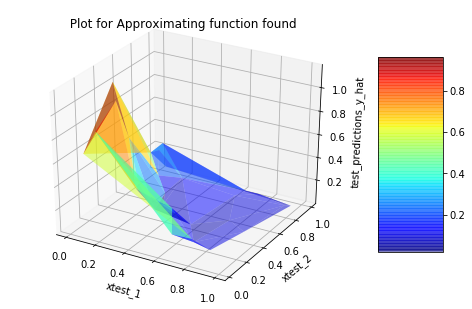

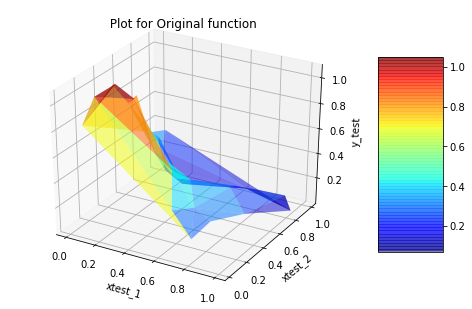

In [16]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X_test[:,0].flatten(), X_test[:,1].flatten(), y_hatrbf_2.flatten(), cmap=cm.jet, 
                       linewidth=0.2, antialiased=True,alpha=0.5)

fig.colorbar(surf, shrink=10, aspect=3)

ax.set_xlabel('xtest_1')
ax.set_ylabel('xtest_2')
ax.set_zlabel('test_predictions_y_hat')
plt.title(' Plot for Approximating function found ')
plt.show()


fig2 = plt.figure()
ax2 = Axes3D(fig2)
surf = ax2.plot_trisurf(X_test[:,0].flatten(), X_test[:,1].flatten(), y_test.flatten(), cmap=cm.jet, linewidth=0.1,alpha=0.5)
fig2.colorbar(surf, shrink=10, aspect=3)

ax2.set_xlabel('xtest_1')
ax2.set_ylabel('xtest_2')
ax2.set_zlabel('y_test')
plt.title(' Plot for Original function ')
plt.show()



## Two Block Decomposition Method for RBF networks. 

Standard descent methods, such as reduced-memory quasi-Newton methods or conjugate gradient methods, can provide efficient training algorithms, in the context of some learning strategy based on regularization or on early
stopping rules. A potentially useful alternative is the two block decomposition scheme.

Pros:
This method of training the RBF networks, as the authors say,  typically yields a reduction in the number of objective function evaluations and hence  reduced  training  times. Also, usually the other existing methods of optimizing this problem might get trapped at local minmas which maybe prevented in this Two block decomposition scheme.

Cons: The convergence rate of this method is inferior to the standard methods. Thus, if high precision is not required in the location of a minimizer, a decomposition approach may yield even more significant computational gains, in comparison with the joint optimization with respect to c and v.


The two block decomposition method alternates the convex minimization with respect to the output weights v and the non convex minimization with respect to the other parameters (either (w,b) for the MLP or the centers c for the RBF network respectively).

more info here:

     https://flore.unifi.it/retrieve/handle/2158/256061/4663/NeuralComputation01.pdf

### Algorithm 


![title](twoblock.png)

remark: the notations in the image and the code might differ

In [15]:
##### main algorithm : two block decomposition ####
def two_block(v,c,X,y,roh,sigma):
    
    tol = [1e-6,1e-3]
    #J = nd.Jacobian(cost_function_rbf_c)
    #J(cc.flatten(),vv,X_train,y_train,3,1)
    lst = []
    func_eval = 0
    grad_eval = 0
    while(True):
        ### optimize v ####
        res_v = minimize(cost_function_rbf, v,args=(c,X,y,roh,sigma)
                 ,method='CG',jac=grad_v,options={'disp': True,'maxiter':30000})
        v_hat = res_v.x
        func_eval =func_eval+ res_v.nfev
        norm = np.linalg.norm(J(c.flatten(),v_hat,X,y,roh,sigma), ord=2)    # l2norm of gradient dE/dc evaluated at v_hat 
        if (norm >= tol[0] and norm <= tol[1]):
            break
        
        ### optimize c ###
        #return(v_hat)
        res_c = minimize(cost_function_rbf_c, c.flatten(),args=(v_hat,X,y,roh,sigma)
                 ,method='CG',options={'disp': True,'maxiter':30000})
        ### update parameters #####
        lst.append(cost_function_rbf(v_hat,c,X,y,roh,sigma))
        grad_eval = grad_eval+res_c.njev

        v = v_hat
        c = res_c.x
    print('out of the loop')
    return v_hat,c,func_eval,grad_eval

In [16]:
### Two Block Decomposition Method ####


def gauss_3(t,ci,sigma):
    
    #c=c.reshape(len(c),1)
    k = np.sqrt(np.sum((abs(t-ci)**2),axis = 1))
    k2 = abs(t - ci)
    val = np.exp(-((k/sigma)**2))
    
    return val,k2

    

def fx_rbf_3(X,v,c,sigma):
    
    #dimensions of X  = p x n
    #v  vector of length equal to no of neurons N x 1
    #c  vector of length equal to no of neurons N x 1
    c = c.reshape(v.shape[0],X.shape[1])
    if v.shape[0]!=c.shape[0]:
        raise(Exception('v,c, should have same length !'))
    
    v = v.reshape(len(v),1)
    gauss_mat = np.empty([X.shape[0],v.shape[0]])
    l1_norm_mat = []
    
    for i in range(c.shape[0]):
        g1,g2 = gauss_3(X,c[i],sigma)
        gauss_mat[:,i] = g1
        l1_norm_mat.append(g2)
    
    
    out = np.dot(gauss_mat,v)   #pxN x Nx1 = px1 vector
                            
    return out,gauss_mat,l1_norm_mat


def cost_function_rbf(v,c,X,y,roh,sigma):
    
#     No_nueron_units = 3
#     v = np.empty([No_nueron_units,1])                 #vector of length equal to no of neurons N x 1
#     w = np.empty([No_nueron_units,X.shape[1]])        #matrix of dimension N x n
#     b = np.empty([No_nueron_units,1])                 # N x 1
#     params = [v,w,b]
    
    #v,c = toWZ_rbf(vctr,shapes)
    
    
    reg_term = roh*np.sqrt(np.sum(abs(v)**2) + np.sum(abs(c)**2))
    cost = np.sum((fx_rbf_3(X,v,c,sigma)[0].reshape(X.shape[0],1) - y.reshape(len(y),1))**2)/(2*len(y)) + reg_term


    #gradients = np.hstack([grad_v(X,v,c,sigma,y).flatten(),grad_c(X,v,c,sigma,y).flatten()])
    return cost

def cost_function_rbf_c(c,v,X,y,roh,sigma):
    
#     No_nueron_units = 3
#     v = np.empty([No_nueron_units,1])                 #vector of length equal to no of neurons N x 1
#     w = np.empty([No_nueron_units,X.shape[1]])        #matrix of dimension N x n
#     b = np.empty([No_nueron_units,1])                 # N x 1
#     params = [v,w,b]
    
    #v,c = toWZ_rbf(vctr,shapes)
    
    
    reg_term = roh*np.sqrt(np.sum(abs(v)**2) + np.sum(abs(c)**2))
    cost = np.sum((fx_rbf_3(X,v,c,sigma)[0].reshape(X.shape[0],1) - y.reshape(len(y),1))**2)/(2*len(y)) + reg_term


    #gradients = np.hstack([grad_v(X,v,c,sigma,y).flatten(),grad_c(X,v,c,sigma,y).flatten()])
    return cost



def grad_v(v,c,X,y,roh,sigma):
    
    val,gauss_matrix,dump = fx_rbf_3(X,v,c,sigma)
    values = []
    values = [np.dot(((val.reshape(X.shape[0],1) - y.reshape(len(y),1)).T),gauss_matrix[:,i].reshape(X.shape[0],1)) + (abs(2*v[i])*roh) for i in range(v.shape[0])]
    val1 = (np.array(values) / X.shape[0]) 
    return val1.reshape(val1.shape[0])   #vector of gradients for dE/dv1 , dE/dv2 .....

def grad_c(c,v,X,y,roh,sigma):
    
    c = c.reshape(v.shape[0],X.shape[1])
    val,gauss_matrix,l1_mat = fx_rbf_3(X,v,c,sigma)
    vect = [np.dot((val.reshape(X.shape[0],1) - y.reshape(len(y),1)).T ,(gauss_matrix[:,i] * v[i] * l1_mat[i][0:,0].reshape(X.shape[0]))) + (abs(2*c[i][0])*roh) for i in range(c.shape[0])]
    vect1 = [np.dot((val.reshape(X.shape[0],1) - y.reshape(len(y),1)).T ,(gauss_matrix[:,i] * v[i] * l1_mat[i][0:,1].reshape(X.shape[0]))) + (abs(2*c[i][1])*roh) for i in range(c.shape[0])] 
    value = np.hstack([vect,vect1]).reshape(len(vect)*2,1)
    value = (2*value)/(X.shape[0]*(sigma**2))
    
    return value.reshape(value.shape[0])  #vector of gradients for dE/dc1 , dE/dc2 .....
    
##### main algorithm : two block decomposition ####
def two_block(v,c,X,y,roh,sigma):
    
    tol = [1e-6,1e-3]
    #J = nd.Jacobian(cost_function_rbf_c)
    #J(cc.flatten(),vv,X_train,y_train,3,1)
    lst = []
    func_eval = 0
    grad_eval = 0
    while(True):
        ### optimize v ####
        res_v = minimize(cost_function_rbf, v,args=(c,X,y,roh,sigma)
                 ,method='CG',jac=grad_v,options={'disp': True,'maxiter':30000})
        v_hat = res_v.x
        func_eval =func_eval+ res_v.nfev
        norm = np.linalg.norm(J(c.flatten(),v_hat,X,y,roh,sigma), ord=2)    # l2norm of gradient dE/dc evaluated at v_hat 
        if (norm >= tol[0] and norm <= tol[1]):
            break
        
        ### optimize c ###
        #return(v_hat)
        res_c = minimize(cost_function_rbf_c, c.flatten(),args=(v_hat,X,y,roh,sigma)
                 ,method='CG',options={'disp': True,'maxiter':30000})
        ### update parameters #####
        lst.append(cost_function_rbf(v_hat,c,X,y,roh,sigma))
        grad_eval = grad_eval+res_c.njev

        v = v_hat
        c = res_c.x
    print('out of the loop')
    return v_hat,c,func_eval,grad_eval


def init_parameters_rbf(Num_nuerons = 10, X = data.X_train):

    No_nueron_units = Num_nuerons
    v = np.random.rand(No_nueron_units,1)                 #vector of length equal to no of neurons N x 1
    c = np.random.rand(No_nueron_units,X.shape[1])        # N x n 
    shapes = (v.shape,c.shape)
    vctr = toVector_rbf(v,c)
    
    return(v,c)


In [18]:
import numdifftools as nd 
J = nd.Jacobian(cost_function_rbf_c)
vv,cc = init_parameters_rbf_2(10,X_train)


In [19]:
v_hat_bl,c_hat_bl,f,c = two_block(vv,cc,X_train,y_train,dct_rbf['roh'],dct_rbf['sigma'])

         Current function value: 0.026401
         Iterations: 10
         Function evaluations: 122
         Gradient evaluations: 110
Optimization terminated successfully.
         Current function value: 0.016294
         Iterations: 84
         Function evaluations: 3124
         Gradient evaluations: 142
         Current function value: 0.015410
         Iterations: 9
         Function evaluations: 162
         Gradient evaluations: 150
Optimization terminated successfully.
         Current function value: 0.014638
         Iterations: 87
         Function evaluations: 3080
         Gradient evaluations: 140
         Current function value: 0.013911
         Iterations: 10
         Function evaluations: 177
         Gradient evaluations: 165
Optimization terminated successfully.
         Current function value: 0.010800
         Iterations: 74
         Function evaluations: 2882
         Gradient evaluations: 131
         Current function value: 0.010235
         Iterations: 10
  

In [20]:
y_hat_bl = fx_rbf_3(X_test,v_hat_bl,c_hat_bl,dct_rbf['sigma'])[0] 
# Remove the comments to view the predictions
#pd.DataFrame({'x':y_hat_bl.reshape(30),'y':y_test})

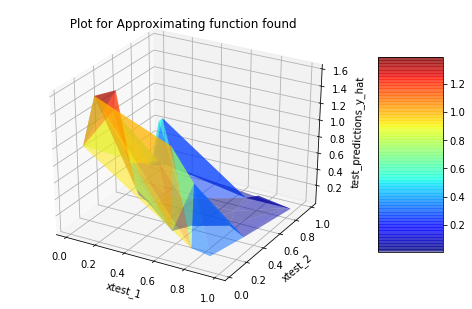

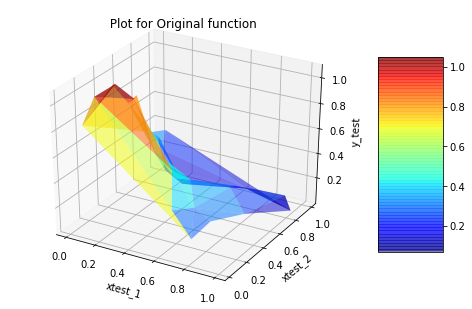

In [21]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X_test[:,0].flatten(), X_test[:,1].flatten(), y_hat_bl.flatten(), cmap=cm.jet, 
                       linewidth=0.2, antialiased=True,alpha=0.5)

fig.colorbar(surf, shrink=10, aspect=3)

ax.set_xlabel('xtest_1')
ax.set_ylabel('xtest_2')
ax.set_zlabel('test_predictions_y_hat')
plt.title(' Plot for Approximating function found ')
plt.show()


fig2 = plt.figure()
ax2 = Axes3D(fig2)
surf = ax2.plot_trisurf(X_test[:,0].flatten(), X_test[:,1].flatten(), y_test.flatten(), cmap=cm.jet, linewidth=0.1,alpha=0.5)
fig2.colorbar(surf, shrink=10, aspect=3)

ax2.set_xlabel('xtest_1')
ax2.set_ylabel('xtest_2')
ax2.set_zlabel('y_test')
plt.title(' Plot for Original function ')
plt.show()



### Final Results 
### Comparison of all the Neural Architectures

![title](comparison.png)

## The End